# League of Legends Win Predictor – Full Pipeline

Pipeline built from scratch: exploratory analysis, robust training flow, reproducible artifacts, and a Flask inference layer, all in one place.


## Workflow Blueprint
- **Data governance**: load the local CSV, validate schema, enforce dtypes.
- **EDA**: summarize distributions, class balance, correlation cues.
- **Feature pipeline**: clean split, scaling, and estimator packaged in a single `sklearn` `Pipeline` for reproducibility.
- **Modeling**: cross-validated logistic regression tuned for class balance.
- **Evaluation**: ROC-AUC, accuracy, confusion matrix, and classification report on the hold-out set.
- **Operationalization**: persist the trained pipeline + metadata for plug-and-play inference.
- **Serving layer**: lightweight Flask API that consumes the saved pipeline and exposes `/predict`.


In [3]:
%%capture
%pip install --quiet pandas numpy seaborn matplotlib scikit-learn joblib flask

In [4]:
import json
from dataclasses import dataclass
from pathlib import Path
from typing import List, Dict

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay,
)
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

plt.style.use("seaborn-v0_8-darkgrid")

@dataclass
class Config:
    project_root: Path = Path.cwd()
    data_path: Path = Path.cwd() / "league_of_legends_data_large.csv"
    artifact_dir: Path = Path.cwd() / "artifacts"
    test_size: float = 0.2
    random_state: int = 42
    target_col: str = "win"

    def ensure_dirs(self) -> None:
        self.artifact_dir.mkdir(parents=True, exist_ok=True)


def enforce_schema(df: pd.DataFrame, expected_cols: List[str]) -> pd.DataFrame:
    missing = set(expected_cols) - set(df.columns)
    if missing:
        raise ValueError(f"Dataset is missing columns: {missing}")
    df = df[expected_cols].copy()
    numeric_cols = [col for col in expected_cols]
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")
    return df


CFG = Config()
CFG.ensure_dirs()
print(f"Working in: {CFG.project_root}")
print(f"Artifacts -> {CFG.artifact_dir}")


Working in: d:\AI_Diploma\AI_diploma\Pytorch\notebook\projects\league_of_legends_data_large
Artifacts -> d:\AI_Diploma\AI_diploma\Pytorch\notebook\projects\league_of_legends_data_large\artifacts


In [5]:
raw_df = pd.read_csv(CFG.data_path)
expected_columns = ["win", "kills", "deaths", "assists", "gold_earned", "cs", "wards_placed", "wards_killed", "damage_dealt"]
df = enforce_schema(raw_df, expected_columns)

print(df.shape)
df.head()


(1000, 9)


,win,kills,deaths,assists,gold_earned,cs,wards_placed,wards_killed,damage_dealt
0,0,16,6,19,17088,231,11,7,15367
1,1,8,8,5,14865,259,10,2,38332
2,0,0,17,11,15919,169,14,5,24642
3,0,19,11,1,11534,264,14,3,15789
4,0,12,7,6,18926,124,15,7,40268


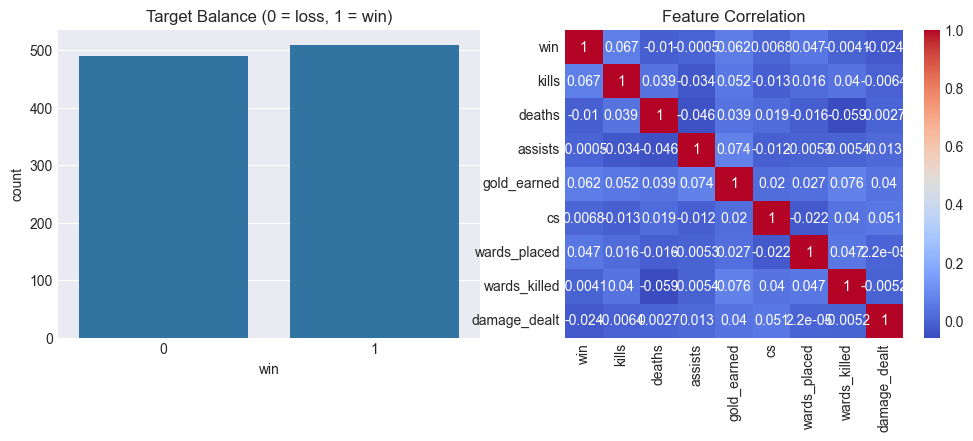

,count,mean,std,min,25%,50%,75%,max
win,1000.0,0.510,0.500150,0.0,0.00,1.0,1.00,1.0
kills,1000.0,9.332,5.798569,0.0,4.00,9.0,14.00,19.0
deaths,1000.0,9.487,5.773488,0.0,4.00,9.0,14.00,19.0
assists,1000.0,9.395,5.765086,0.0,4.00,10.0,14.00,19.0
gold_earned,1000.0,12433.808,4388.138751,5002.0,8551.75,12295.0,16348.25,19955.0
cs,1000.0,181.213,72.114910,50.0,121.00,183.5,243.00,299.0
wards_placed,1000.0,9.834,5.739633,0.0,5.00,10.0,15.00,19.0
wards_killed,1000.0,4.541,2.906332,0.0,2.00,5.0,7.00,9.0
damage_dealt,1000.0,27484.905,13221.571932,5028.0,15759.00,27370.0,39453.00,49927.0


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(data=df, x=CFG.target_col, ax=axes[0])
axes[0].set_title("Target Balance (0 = loss, 1 = win)")

sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", ax=axes[1])
axes[1].set_title("Feature Correlation")
plt.show()

df.describe().T


In [7]:
feature_cols = [col for col in df.columns if col != CFG.target_col]
X = df[feature_cols]
y = df[CFG.target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=CFG.test_size,
    random_state=CFG.random_state,
    stratify=y,
)

print(f"Train samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")


Train samples: 800
Test samples: 200


In [8]:
log_reg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    (
        "classifier",
        LogisticRegression(
            penalty="l2",
            C=1.0,
            max_iter=1000,
            class_weight="balanced",
            random_state=CFG.random_state,
        ),
    ),
])

cv_auc = cross_val_score(
    log_reg_pipeline,
    X_train,
    y_train,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
)
print(f"5-Fold ROC-AUC: {cv_auc.mean():.3f} ± {cv_auc.std():.3f}")

log_reg_pipeline.fit(X_train, y_train)
print("Pipeline fitted.")


5-Fold ROC-AUC: 0.481 ± 0.025
Pipeline fitted.


{'accuracy': 0.52, 'roc_auc': 0.585234093637455}

Classification Report
               precision    recall  f1-score   support

           0       0.51      0.51      0.51        98
           1       0.53      0.53      0.53       102

    accuracy                           0.52       200
   macro avg       0.52      0.52      0.52       200
weighted avg       0.52      0.52      0.52       200



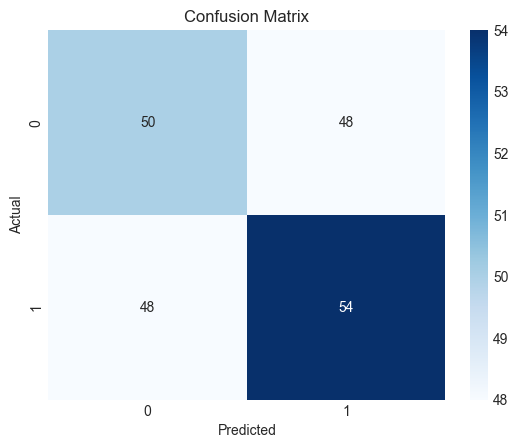

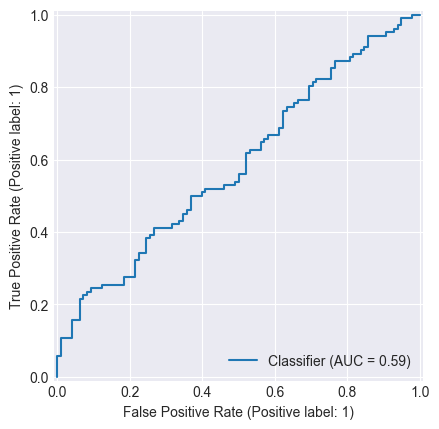

In [9]:
y_pred_proba = log_reg_pipeline.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_pred_proba),
}
print(metrics)
print("\nClassification Report\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_pred_proba)
plt.show()


In [10]:
pipeline_path = CFG.artifact_dir / "lol_win_pipeline.joblib"
metadata_path = CFG.artifact_dir / "metadata.json"

joblib.dump(log_reg_pipeline, pipeline_path)
metadata = {
    "feature_order": feature_cols,
    "target": CFG.target_col,
    "test_metrics": metrics,
}
metadata_path.write_text(json.dumps(metadata, indent=2))

print(f"Saved pipeline to {pipeline_path}")
print(metadata)


Saved pipeline to d:\AI_Diploma\AI_diploma\Pytorch\notebook\projects\league_of_legends_data_large\artifacts\lol_win_pipeline.joblib
{'feature_order': ['kills', 'deaths', 'assists', 'gold_earned', 'cs', 'wards_placed', 'wards_killed', 'damage_dealt'], 'target': 'win', 'test_metrics': {'accuracy': 0.52, 'roc_auc': 0.585234093637455}}


In [11]:
def predict_match_outcome(sample: Dict[str, float]) -> Dict[str, float]:
    """Simple helper to run ad-hoc predictions with the persisted pipeline."""
    loaded_pipeline = joblib.load(pipeline_path)
    ordered_values = np.array([sample[col] for col in feature_cols]).reshape(1, -1)
    win_prob = loaded_pipeline.predict_proba(ordered_values)[0, 1]
    return {"win_probability": float(win_prob), "prediction": int(win_prob >= 0.5)}

example_input = {
    "kills": 15,
    "deaths": 8,
    "assists": 12,
    "gold_earned": 52000,
    "cs": 250,
    "wards_placed": 12,
    "wards_killed": 3,
    "damage_dealt": 40000,
}
predict_match_outcome(example_input)


d:\AI_Diploma\AI_diploma\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


{'win_probability': 0.6400761860513131, 'prediction': 1}

## Flask Serving Layer
The next Python file lives alongside this notebook and loads the persisted pipeline. Boot it locally with `python service/api.py` after running the notebook once so the artifacts exist.


In [12]:
from textwrap import dedent
print(
    dedent(
        """
        $ python -m venv .venv && .venv\\Scripts\\activate
        $ pip install -r requirements.txt  # or install flask + joblib manually
        $ python service/api.py
        -> POST http://127.0.0.1:8000/predict with JSON body matching `feature_order`
        """
    )
)



$ python -m venv .venv && .venv\Scripts\activate
$ pip install -r requirements.txt  # or install flask + joblib manually
$ python service/api.py
-> POST http://127.0.0.1:8000/predict with JSON body matching `feature_order`

